# Loading Libraries

In [1]:
import numpy as np
import pandas as pd

# import nltk
# from nltk import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder



from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions We Use

In [13]:
def print_results(model, X_train, y_train,X_test, y_test):

    

#     print(f"""{list(le.transform([l_classes[0]]))[0]} ----> {list(le.classes_)[0]} 
# {list(le.transform([l_classes[1]]))[0]} ----> {list(le.classes_)[1]} """)
    
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"2": f"{list(le.inverse_transform([2]))[0]}",
                             "1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    return report

# Importing Data

In [3]:
data = pd.read_csv("EDA/cleaned_data/cleaned.csv")
data.drop("Unnamed: 0", axis = 1, inplace = True)
data["lemmatized_text"] = data["lemmatized_text"].apply(
    lambda x: x.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(","))

data["cleaned_text"] = data["lemmatized_text"].apply(lambda x: " ".join(x))
data.head()

,text,label,cleaned_text,lemmatized_text,neg,neu,pos,compound
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,neg,3g iphone hrs tweet rise_austin dead need upgr...,"[3g, iphone, hrs, tweet, rise_austin, dead, ne...",0.213,0.787,0.000,-0.6800
1,@jessedee Know about @fludapp ? Awesome iPad/i...,pos,know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app...",0.000,0.545,0.455,0.9100
2,@swonderlin Can not wait for #iPad 2 also. The...,pos,wait ipad also sale,"[wait, ipad, also, sale]",0.000,1.000,0.000,0.0000
3,@sxsw I hope this year's festival isn't as cra...,neg,hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]",0.000,0.643,0.357,0.7269
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,pos,great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti...",0.000,0.785,0.215,0.6249


In [4]:
data.iloc[0].lemmatized_text

['3g',
 'iphone',
 'hrs',
 'tweet',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station']

# Train Test Split

In [5]:
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

df = data[["cleaned_text", 'neg', 'neu', 'pos', 'compound']]
y = data["label_encoded"]


X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

num = ['neg', 'neu', 'pos', 'compound']
text = ["cleaned_text"]

X_num_train = X_train[num]
X_num_test  = X_test[num]

X_text_train = X_train[text]
X_text_test  = X_test[text]

In [6]:
y_train.value_counts(normalize = True) * 100

1    59.563290
2    32.457725
0     7.978985
Name: label_encoded, dtype: float64

In [7]:
y_test.value_counts(normalize = True) * 100

1    58.647118
2    33.355548
0     7.997334
Name: label_encoded, dtype: float64

# TF-IDF for word count and modeling

## TF-IDF

### Making Pipelines

In [11]:
def itself(data):
    
    return data


# Column Transformation

col_transformer = ColumnTransformer(
transformers=[
("tfidf", TfidfVectorizer(max_features=10000),"cleaned_text"),
("itself", FunctionTransformer(itself), ['neg', 'neu', 'pos', 
                                         'compound'])
             ],    remainder="drop")



# Logistic Regression

lr = Pipeline([
("col transformer", col_transformer),
("Logistic Regression", LogisticRegression(class_weight="balanced",
                                           solver='liblinear',random_state=42))
              ])

# Decision Tree

tree = Pipeline([
("col transformer", col_transformer),
("Decision Tree",DecisionTreeClassifier(class_weight="balanced",criterion ="gini",
                                  max_depth = 20, random_state = 42))    
                ])

# Random Forest

forest = Pipeline([
("col transformer", col_transformer),
("Random Forest",RandomForestClassifier(criterion="entropy", n_estimators=20,
                            bootstrap = True, random_state = 42))   
    
                 ])

# XGBoost

xgboost = Pipeline([
("col transformer", col_transformer),
("xgb", xgb.XGBClassifier(max_depth=20,n_estimators=20,seed=42,
                  objective='binary:logistic', eval_metric = 'logloss'))
                  ])


# LightGBM
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'max_depth':20,
        'eval_metric':"cross_entropy",
        'verbose':0,
        'random_seed': 42,
        'class_weight' :  'balanced',
        'force_row_wise' : True
          }

light = Pipeline([
("col transformer", col_transformer),
("lgbm", lgb.LGBMClassifier(**params))
])
 
    
    
models = [("Logistic Regression", lr),
          ("Decision Tree", tree),
          ("Random Forest", forest),
          ("xgb", xgboost),
          ("lgbm", light)]    

### Logistic Regression

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.418327     0.724854     0.610792  0.666111     0.584658   
      recall       0.437500     0.773864     0.531469  0.666111     0.580944   
      f1-score     0.427699     0.748557     0.568376  0.666111     0.581544   
      support    240.000000  1760.000000  1001.000000  0.666111  3001.000000   
TRAIN precision    0.660441     0.829391     0.771708  0.796585     0.753847   
      recall       0.800412     0.860254     0.678806  0.796585     0.779824   
      f1-score     0.723721     0.844541     0.722282  0.796585     0.763515   
      support    486.000000  3628.000000  1977.000000  0.796585  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.662294  
      recall         0.666111  
      f1-score       0.662797  
      support     3001.000000  
TRAIN precision      0.797188  
      recall         0.796585  
      f1-score       0.795218  
      support     6091.000000

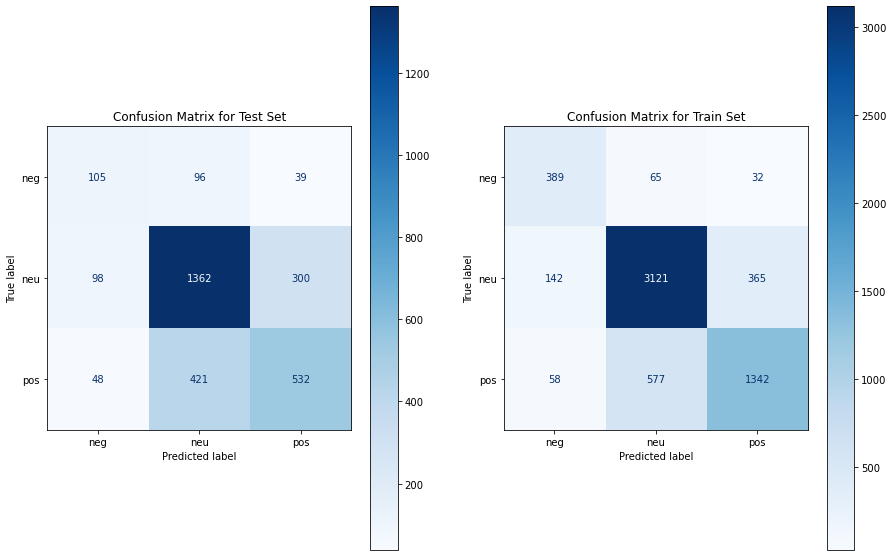

In [19]:
print_results(lr.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### Decision Tree

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.300836     0.697392     0.505539  0.586471     0.501256   
      recall       0.450000     0.653409     0.501499  0.586471     0.534969   
      f1-score     0.360601     0.674685     0.503511  0.586471     0.512932   
      support    240.000000  1760.000000  1001.000000  0.586471  3001.000000   
TRAIN precision    0.601100     0.876835     0.761717  0.805615     0.746551   
      recall       0.899177     0.806505     0.780981  0.805615     0.828888   
      f1-score     0.720528     0.840201     0.771229  0.805615     0.777319   
      support    486.000000  3628.000000  1977.000000  0.805615  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.601685  
      recall         0.586471  
      f1-score       0.592470  
      support     3001.000000  
TRAIN precision      0.817470  
      recall         0.805615  
      f1-score       0.808265  
      support     6091.000000

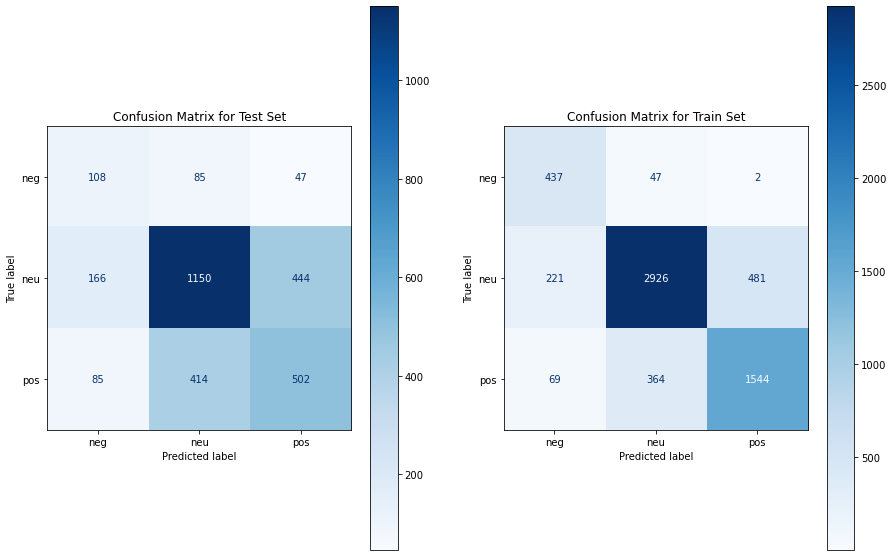

In [15]:
print_results(tree.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### Random Forest

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.605263     0.677155     0.616120  0.660447     0.632846   
      recall       0.191667     0.843750     0.450549  0.660447     0.495322   
      f1-score     0.291139     0.751328     0.520485  0.660447     0.520984   
      support    240.000000  1760.000000  1001.000000  0.660447  3001.000000   
TRAIN precision    0.974895     0.966909     0.986287  0.973568     0.976030   
      recall       0.958848     0.990628     0.945878  0.973568     0.965118   
      f1-score     0.966805     0.978625     0.965660  0.973568     0.970363   
      support    486.000000  3628.000000  1977.000000  0.973568  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.651047  
      recall         0.660447  
      f1-score       0.637526  
      support     3001.000000  
TRAIN precision      0.973836  
      recall         0.973568  
      f1-score       0.973474  
      support     6091.000000

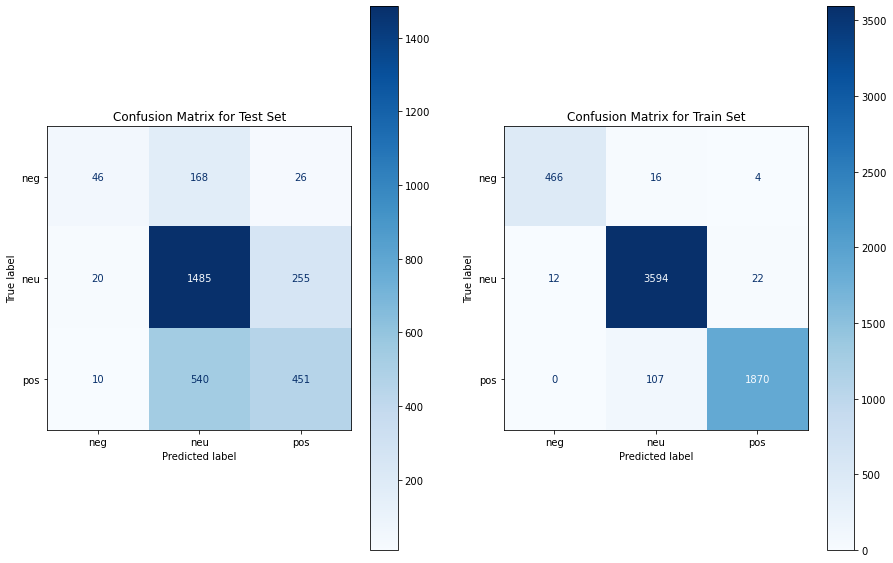

In [16]:
print_results(forest.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### XGBoost

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.552083     0.697176     0.605170  0.666445     0.618143   
      recall       0.220833     0.813636     0.514486  0.666445     0.516318   
      f1-score     0.315476     0.750918     0.556156  0.666445     0.540850   
      support    240.000000  1760.000000  1001.000000  0.666445  3001.000000   
TRAIN precision    0.987654     0.917833     0.982906  0.941225     0.962798   
      recall       0.823045     0.994487     0.872534  0.941225     0.896689   
      f1-score     0.897868     0.954624     0.924437  0.941225     0.925643   
      support    486.000000  3628.000000  1977.000000  0.941225  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.654884  
      recall         0.666445  
      f1-score       0.651130  
      support     3001.000000  
TRAIN precision      0.944525  
      recall         0.941225  
      f1-score       0.940297  
      support     6091.000000

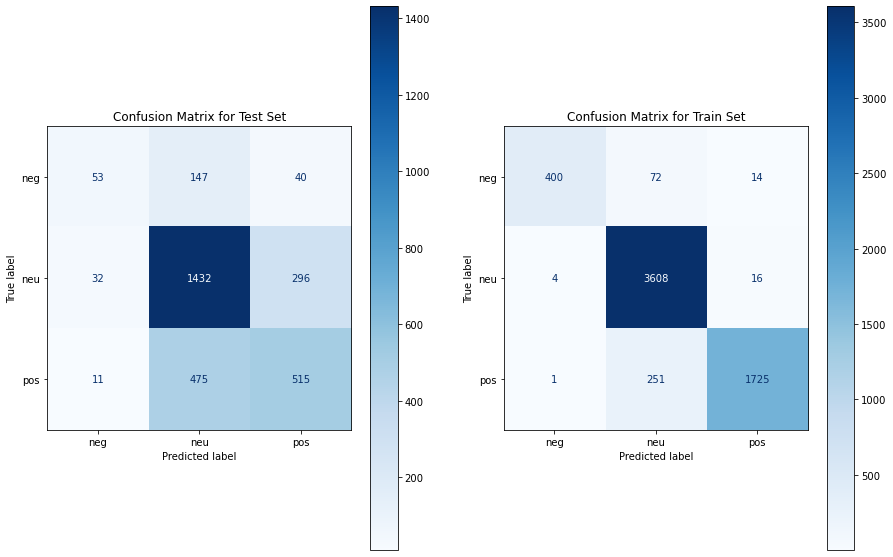

In [17]:
print_results(xgboost.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### LightGBM

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.235099     0.751852     0.527221  0.569477     0.504724   
      recall       0.591667     0.576705     0.551449  0.569477     0.573273   
      f1-score     0.336493     0.652733     0.539062  0.569477     0.509430   
      support    240.000000  1760.000000  1001.000000  0.569477  3001.000000   
TRAIN precision    0.322163     0.842086     0.645742  0.663766     0.603330   
      recall       0.870370     0.632029     0.671219  0.663766     0.724539   
      f1-score     0.470261     0.722091     0.658234  0.663766     0.616862   
      support    486.000000  3628.000000  1977.000000  0.663766  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.635598  
      recall         0.569477  
      f1-score       0.589527  
      support     3001.000000  
TRAIN precision      0.736873  
      recall         0.663766  
      f1-score       0.681271  
      support     6091.000000

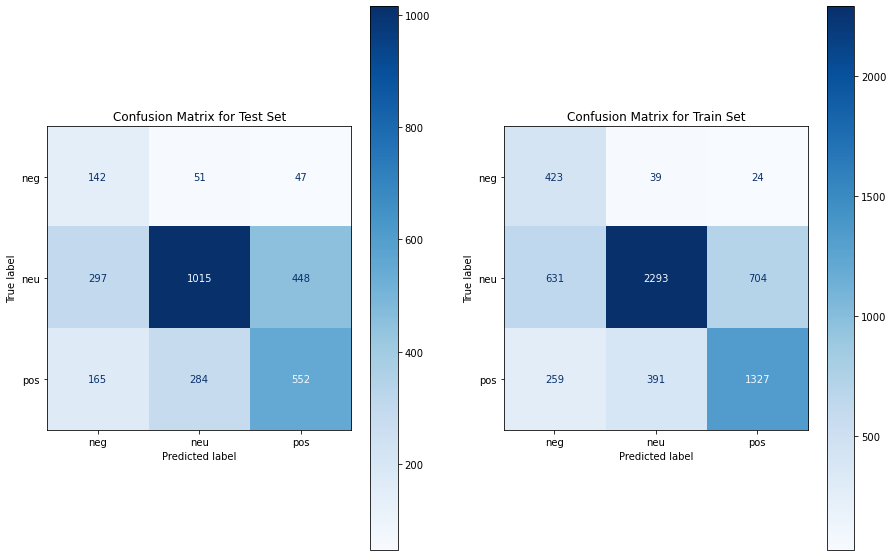

In [18]:
print_results(light.fit(X_train, y_train), X_train, y_train, X_test, y_test)

## Creating Samples with SMOTE()

### Making Pipelines

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state = 42)
def itself(data):
    
    return data


# Column Transformation

col_transformer = ColumnTransformer(
transformers=[
("tfidf", TfidfVectorizer(max_features=10000),"cleaned_text"),
# ("itself", FunctionTransformer(itself), ['neg', 'neu', 'pos', 'compound']),
             ],    remainder="drop")



# Logistic Regression

lr_smote = Pipeline(steps = [
("col transformer", col_transformer),
 ('smote', smt),
("Logistic Regression", LogisticRegression(class_weight="balanced",
                                           solver='liblinear',random_state=42))
              ])

# Decision Tree

tree_smote = Pipeline(steps = [
("col transformer", col_transformer),
('smote',smt),
("Decision Tree",DecisionTreeClassifier(class_weight="balanced",criterion ="gini",
                                  max_depth = 20, random_state = 42))    
                ])

# Random Forest

forest_smote = Pipeline(steps = [
("col transformer", col_transformer),   
('smote',smt),
("Random Forest",RandomForestClassifier(criterion="entropy", n_estimators=20,
                            bootstrap = True, random_state = 42))   
    
                 ])

# XGBoost

xgboost_smote = Pipeline(steps = [
("col transformer", col_transformer),    
('smote',smt),
("xgb", xgb.XGBClassifier(max_depth=20,n_estimators=20,seed=42,
                  objective='binary:logistic', eval_metric = 'logloss'))
                  ])


# LightGBM
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'max_depth':20,
        'eval_metric':"cross_entropy",
        'verbose':0,
        'random_seed': 42,
        'class_weight' :  'balanced',
        'force_row_wise' : True
          }

light_smote = Pipeline(steps = [
("col transformer", col_transformer),
('smote',smt),
("lgbm", lgb.LGBMClassifier(**params))
])
 
    
    
models = [("Logistic Regression", lr_smote),
          ("Decision Tree", tree_smote),
          ("Random Forest", forest_smote),
          ("xgb", xgboost_smote),
          ("lgbm", light_smote)]    

### Logistic Regression

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.310777     0.750795     0.556851  0.625791     0.539474   
      recall       0.516667     0.671023     0.572428  0.625791     0.586706   
      f1-score     0.388106     0.708671     0.564532  0.625791     0.553770   
      support    240.000000  1760.000000  1001.000000  0.625791  3001.000000   
TRAIN precision    0.540925     0.885221     0.750872  0.793302     0.725673   
      recall       0.938272     0.790794     0.762266  0.793302     0.830444   
      f1-score     0.686230     0.835347     0.756526  0.793302     0.759368   
      support    486.000000  3628.000000  1977.000000  0.793302  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.650914  
      recall         0.625791  
      f1-score       0.634956  
      support     3001.000000  
TRAIN precision      0.814143  
      recall         0.793302  
      f1-score       0.797866  
      support     6091.000000

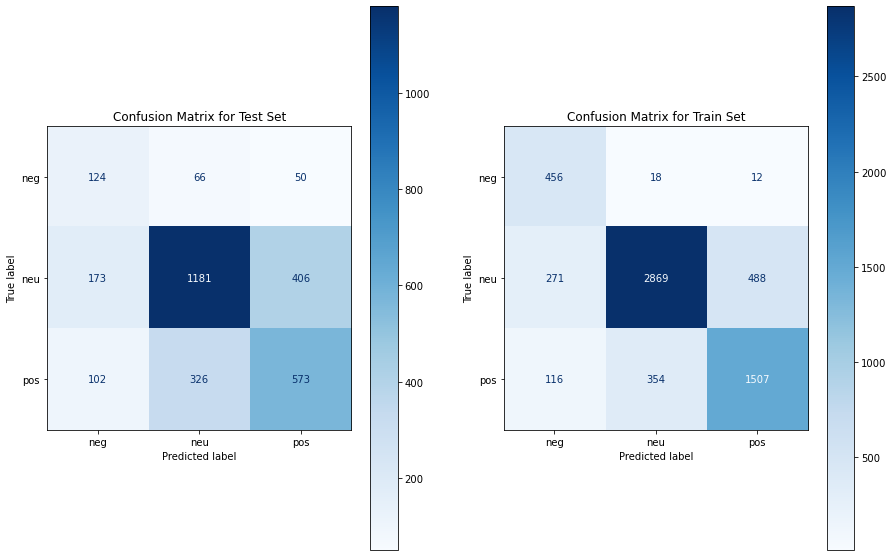

In [35]:
print_results(lr_smote.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### Decision Tree

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.272222     0.664896     0.482942  0.584472     0.473354   
      recall       0.204167     0.711364     0.452547  0.584472     0.456026   
      f1-score     0.233333     0.687346     0.467251  0.584472     0.462643   
      support    240.000000  1760.000000  1001.000000  0.584472  3001.000000   
TRAIN precision    0.785326     0.763430     0.636953  0.726318     0.728570   
      recall       0.594650     0.814774     0.596358  0.726318     0.668594   
      f1-score     0.676815     0.788267     0.615987  0.726318     0.693690   
      support    486.000000  3628.000000  1977.000000  0.726318  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.572801  
      recall         0.584472  
      f1-score       0.577623  
      support     3001.000000  
TRAIN precision      0.724125  
      recall         0.726318  
      f1-score       0.723456  
      support     6091.000000

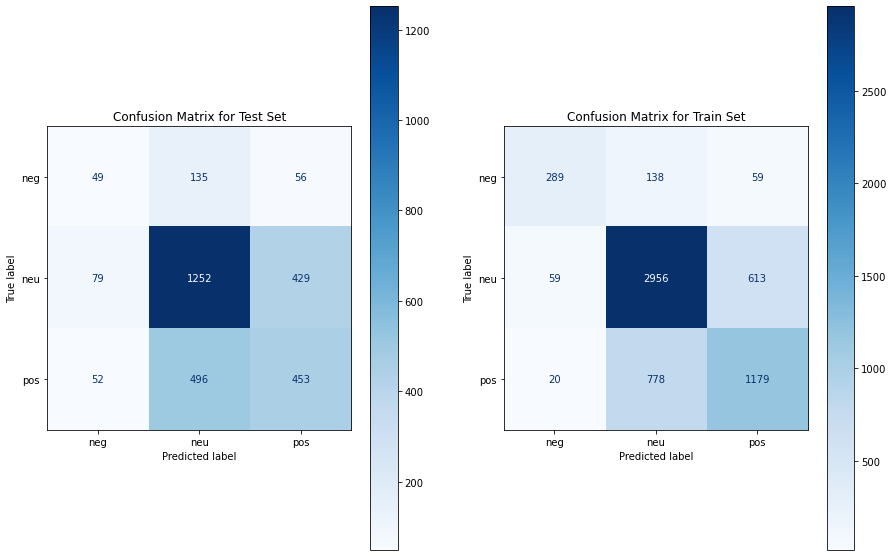

In [36]:
print_results(tree_smote.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### Random Forest

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.518182     0.681818     0.596919  0.653782     0.598973   
      recall       0.237500     0.818182     0.464535  0.653782     0.506739   
      f1-score     0.325714     0.743802     0.522472  0.653782     0.530663   
      support    240.000000  1760.000000  1001.000000  0.653782  3001.000000   
TRAIN precision    0.934524     0.967574     0.958419  0.961911     0.953505   
      recall       0.969136     0.970507     0.944360  0.961911     0.961334   
      f1-score     0.951515     0.969038     0.951338  0.961911     0.957297   
      support    486.000000  3628.000000  1977.000000  0.961911  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.640413  
      recall         0.653782  
      f1-score       0.636540  
      support     3001.000000  
TRAIN precision      0.961965  
      recall         0.961911  
      f1-score       0.961895  
      support     6091.000000

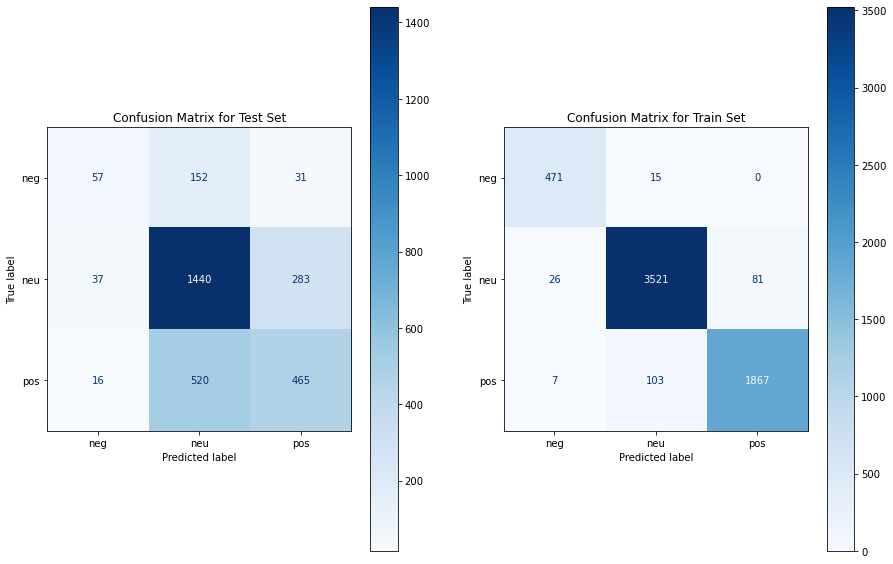

In [37]:
print_results(forest_smote.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### XGBoost

neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.430769     0.686923     0.589681  0.649450     0.569124   
      recall       0.233333     0.802841     0.479520  0.649450     0.505232   
      f1-score     0.302703     0.740372     0.528926  0.649450     0.524000   
      support    240.000000  1760.000000  1001.000000  0.649450  3001.000000   
TRAIN precision    0.948370     0.844683     0.940182  0.875062     0.911078   
      recall       0.718107     0.974366     0.731411  0.875062     0.807961   
      f1-score     0.817330     0.904902     0.822760  0.875062     0.848331   
      support    486.000000  3628.000000  1977.000000  0.875062  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.634002  
      recall         0.649450  
      f1-score       0.634841  
      support     3001.000000  
TRAIN precision      0.883953  
      recall         0.875062  
      f1-score       0.871253  
      support     6091.000000

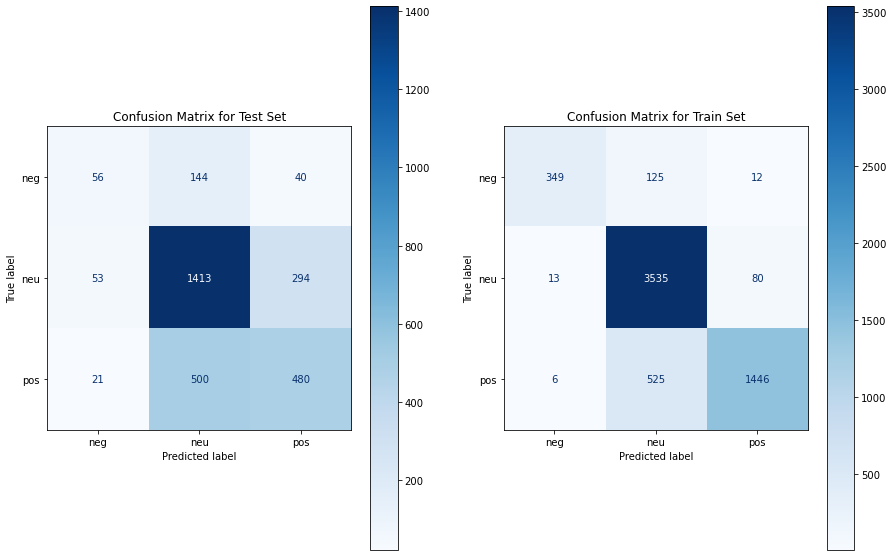

In [38]:
print_results(xgboost_smote.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### LightGBM

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


neg          neu          pos  accuracy    macro avg  \
data  index                                                                    
TEST  precision    0.287565     0.733537     0.564103  0.621126     0.528401   
      recall       0.462500     0.683523     0.549451  0.621126     0.565158   
      f1-score     0.354633     0.707647     0.556680  0.621126     0.539653   
      support    240.000000  1760.000000  1001.000000  0.621126  3001.000000   
TRAIN precision    0.387214     0.795625     0.652987  0.694960     0.611942   
      recall       0.660494     0.731808     0.635812  0.694960     0.676038   
      f1-score     0.488213     0.762383     0.644285  0.694960     0.631627   
      support    486.000000  3628.000000  1977.000000  0.694960  6091.000000   

                 weighted avg  
data  index                    
TEST  precision      0.641355  
      recall         0.621126  
      f1-score       0.629059  
      support     3001.000000  
TRAIN precision      0.716741  
      recall         0.694960  
      f1-score       0.702175  
      support     6091.000000

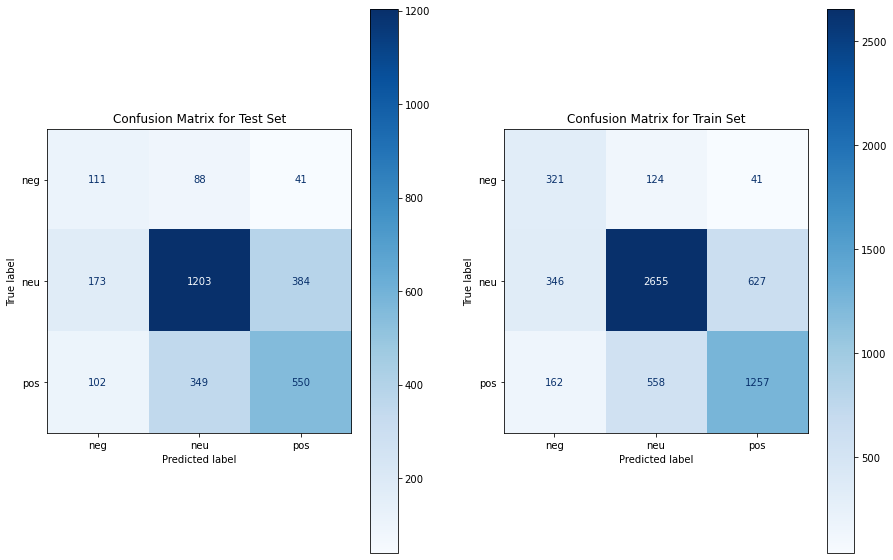

In [33]:
print_results(light_smote.fit(X_train, y_train), X_train, y_train, X_test, y_test)